In [1]:
!pip install dgl
#!DGLBACKEND=pytorch
#!export $DGLBACKEND
#import os
#os.environ["DGLBACKEND"] = "pytorch"
#print(os.environ["DGLBACKEND"])
import dgl
import numpy as np
#import tensorflow as tf
import torch as th

!pip install forgi
import forgi
import forgi.graph.bulge_graph as fgb
import forgi.threedee as ft
import forgi.threedee.model.coarse_grain as ftmc


import matplotlib.pyplot as plt
import networkx as nx

     |████████████████████████████████| 4.4 MB 4.7 MB/s 
Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


     |████████████████████████████████| 26.6 MB 61 kB/s 
     |████████████████████████████████| 2.3 MB 36.7 MB/s 
  Created wheel for forgi: filename=forgi-2.0.2-cp37-cp37m-linux_x86_64.whl size=27429375 sha256=6e7b3c6224eefa296eded0bf7857bd6f374460bd47bf8f6c5073a0cce7f4e203
  Stored in directory: /root/.cache/pip/wheels/ce/5d/b2/aa4d2d9454b124485448d838d5d02bce20f5546aa9b9d40b55
Successfully built forgi


In [2]:
th.__version__

'1.10.0+cu111'


Ideas: 
*   load coarse grain representation with forgi,
*   use forgi to form a graph with nodes labeled as s/i/o/.. and twist, length, angle,...
*   use that graph to feed into model
*   use dgl.save_graph() to store a graph, so the structure can be used for several steps?
*   use forgi.threedee.model.coarse_grain.CoarseGrainRNA.rotate() to rotate cg RNAs and see if the classification changes

TODO:
*  build dataloader
*      build model
*      simulate batches to train (while testing)
*    future --> find where ernwin writes/stores output of structure for each n steps



In [3]:
#Graph Building

#load coarse grain file
def load_cg_file(file): 
    cg = ftmc.CoarseGrainRNA.from_bg_file(file) 
    c_dict = dict(cg.coords)
    t_dict = dict(cg.twists)
    coord_dict = {}
    twist_dict = {}
    for e in c_dict:
        a = th.from_numpy(c_dict[e][0])
        b = th.from_numpy(c_dict[e][1])
        coord_dict[e] = a, b
        if e in t_dict:
            c = th.from_numpy(t_dict[e][0])
            d = th.from_numpy(t_dict[e][1])
            twist_dict[e] = c, d
        
    # Get elements and neighbours:
    connections = {}
    for elem in cg.sorted_element_iterator():
        neighbours = cg.connections(elem)
        if elem not in connections:
            connections[elem] = cg.connections(elem)
    return coord_dict, twist_dict, connections

def build_dgl_graph(coord_dict, twist_dict, connections):
    #dictionary to convert type
    type_transl = {
        "h": [1, 0, 0, 0, 0, 0],
        "i": [0, 1, 0, 0, 0, 0],
        "m": [0, 0, 1, 0, 0, 0],
        "s": [0, 0, 0, 1, 0, 0],
        "f": [0, 0, 0, 0, 1, 0],
        "t": [0, 0, 0, 0, 0, 1]
    } 

    #encode nodes numerically for dgl graph
    num_graph = {}
    elem_count = {}
    for num, n in enumerate(sorted(connections)):
        num_graph[n] = num
        if n[0] not in elem_count:
            elem_count[n[0]] = 1
        else:
            elem_count[n[0]] += 1

    #build graph and edges
    u = []
    v = []
    for node in connections:
        for c in connections[node]:
            u.append(num_graph[node])
            v.append(num_graph[c])

    graph = dgl.graph((th.tensor(u), th.tensor(v)))

    #initialise node attributes
    graph.ndata["type"] = th.zeros(graph.num_nodes(), 6, dtype=th.float32)
    graph.ndata["coord"] = th.zeros(graph.num_nodes(), 6, dtype=th.float32) #seperate coords into 2 sets of 3, so that the information of start and end is added?
    graph.ndata["twist"] = th.zeros(graph.num_nodes(), 6, dtype=th.float32)

    for elem in connections:
        graph.ndata["type"][num_graph[elem]] = th.tensor(type_transl[elem[0]], dtype=th.float32) 
        graph.ndata["coord"][num_graph[elem]] = th.tensor(np.concatenate(coord_dict[elem]), dtype=th.float32)
        if elem in twist_dict:
            graph.ndata["twist"][num_graph[elem]] = th.tensor(np.concatenate(twist_dict[elem]), dtype=th.float32)
  
    return graph



In [6]:
#Graph Dataset Class
#TODO: adapt, so it can stand alone

from dgl.data import DGLDataset
class CGDataset(DGLDataset):
    def __init__(self):
        super().__init__(name="cgRNA")
  
    def process(self):
        self.graphs = []
        self.labels = [12.722, 4.891, 22.918]

        for struc in ["6cu1.cg", "2mis.cg", "1p5p.cg"]:
            coord_dict, twist_dict, connections = load_cg_file(struc)
            self.graphs.append(build_dgl_graph(coord_dict, twist_dict, connections))

        self.labels = th.tensor(self.labels)
  
    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)


In [83]:
g_list = []
glabels ={"rmsd": th.tensor([12.722, 4.891, 22.918])} #done with: compare_RNA.py data/6CU1.pdb /home/mescalin/mgeyer/3d_classifier/6cu1.cg

for struc in ["6cu1.cg", "2mis.cg", "1p5p.cg"]:
    coord_dict, twist_dict, connections = load_cg_file(struc)
    graph = build_dgl_graph(coord_dict, twist_dict, connections)
    g_list.append(graph)

# save_graphs, label is rmsd
dgl.save_graphs("cg_graphs.dgl", g_list, labels=glabels)
gs, ls = dgl.load_graphs("cg_graphs.dgl")
#print(gs)
#print(ls)

In [218]:
#Dataloading
import dgl.dataloading as dtl

b_size = 2

dataset = CGDataset()
#graph, label = dataset[0]
#print(graph, label)


dataloader = dtl.pytorch.GraphDataLoader(dataset, batch_size=b_size, shuffle=True) #add randomisation as in Defining Data Loader from https://docs.dgl.ai/tutorials/blitz/5_graph_classification.html



In [219]:
#Model
from dgl.nn import GraphConv
import torch.nn.functional as F

# feed the 3 different node attributes one after the other though the first layer? like in https://discuss.dgl.ai/t/getting-started-with-multiple-node-features-in-homogenous-graph/919/2
# condense the 3 node attributes down to 1? see point above


#Coarse Grain RNA Classifier Model
class CG_Classifier(th.nn.Module):
    def __init__(self, in_dim, hidden_dim, num_features):
        super(CG_Classifier, self).__init__()
        
        self.conv1 = GraphConv(in_dim, hidden_dim, activation=F.relu)
        self.conv2 = GraphConv(hidden_dim, hidden_dim, activation=F.relu)
        
        self.max_pool = dgl.nn.MaxPooling()
        
        self.dense1 = th.nn.Linear(hidden_dim*num_features, 256)
        self.dense2 = th.nn.Linear(256, 256)
        self.dense3 = th.nn.Linear(256, 256)
        self.classify = th.nn.Linear(256, 1)

    def forward(self, g):#, n_types, n_coord, n_twist):
        nt = g.ndata["type"]
        nc = g.ndata["coord"]
        nw = g.ndata["twist"]

        nt = self.conv1(g, nt)
        nt = self.max_pool(g, nt)
        nt = self.conv2(g, nt)
        nt = self.max_pool(g, nt)
        
        nc = self.conv1(g, nc)
        nc = self.max_pool(g, nc)
        nc = self.conv2(g, nc)
        nc = self.max_pool(g, nc)
        
        nw = self.conv1(g, nw)
        nw = self.max_pool(g, nw)
        nw = self.conv2(g, nw)
        nw = self.max_pool(g, nw)

        #use pooling to have still a graph representation, after 2 layers of seperate conv
        #let conv run over the pooled graph

        tcw = th.cat((nt, nc, nw), 1)

        #is the mean the right approach?
        tcw_mean = tcw.mean(dim=0)
        tcw_mean = self.dense1(tcw_mean)
        tcw_mean = self.dense2(tcw_mean)
        tcw_mean = self.dense3(tcw_mean)
        
        return self.classify(tcw_mean)
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch 0, loss 16.0952
Epoch 5, loss 4172.7042
Epoch 10, loss 2123.8777
Epoch 15, loss 1709.5049
Epoch 20, loss 2636.1611
Epoch 25, loss 178.4339
Epoch 30, loss 824.8105
Epoch 35, loss 81.4117
Epoch 40, loss 28.3745
Epoch 45, loss 7.3078
Epoch 50, loss 6.0316
Epoch 55, loss 4.6573


<function matplotlib.pyplot.draw>

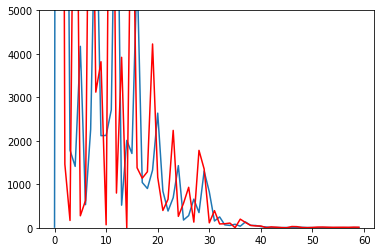

In [243]:
#Training
#TODO: figure out the loss function
#       build a deeper neural network and how to pool
#       tinker with hyperparameters

model = CG_Classifier(
    in_dim=6, #num of pos in type, twist, coord
    hidden_dim=12,
    num_features=3 #len(graph.ndata)
)

opt = th.optim.Adam(model.parameters(), lr=0.1)
model.train()

epochs = 60

#temp val setup --> use dataloader for larger set
val_losses = []
val_label = th.tensor(0.934)
vcoord_dict, vtwist_dict, vconnections = load_cg_file("1ehz.cg")
val_graph = build_dgl_graph(vcoord_dict, vtwist_dict, vconnections)

#training setup
epoch_losses = []
for epoch in range(epochs):
    epoch_loss = 0
    
    for iter, (batch, batch_labels) in enumerate(dataloader):
        batch_loss = th.tensor(0, dtype=th.float32)
        for i, batched_g in enumerate(dgl.unbatch(batch)):
            prediction = model(batched_g)
            batch_loss += F.smooth_l1_loss(prediction, batch_labels[i]) #F.cross_entropy(prediction, label) #th.abs((prediction - label))
        
        #using the mean of all losses of a single batch for backpropagation
        loss = batch_loss/b_size

        opt.zero_grad()
        loss.backward()
        opt.step()
        epoch_loss += loss.detach().item()

    epoch_loss /= (iter + 1)
    if epoch % 5 == 0:
        print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

    #val setup
    val_pred = model(val_graph)
    val_loss = F.smooth_l1_loss(val_pred, val_label)
    val_losses.append(val_loss.detach().item())

#plot the training run
plt.plot(epoch_losses)
plt.plot(val_losses, 'r')
plt.ylim(ymax=5000, ymin=0)
plt.draw

In [244]:
#Test with 1ehz.cg

test_label = th.tensor(0.934)
tcoord_dict, ttwist_dict, tconnections = load_cg_file("1ehz.cg")
test_graph = build_dgl_graph(tcoord_dict, ttwist_dict, tconnections)


#tn_types = test_graph.ndata["type"]
#tn_coord = test_graph.ndata["coord"]
#tn_twist = test_graph.ndata["twist"]

pred = model(test_graph)#, tn_types, tn_coord, tn_twist)
loss = F.smooth_l1_loss(pred, test_label)
print("Predicted RMSD of 1EHZ (3rd best cg with ernwin): {:.4f}; true RMSD: {:.4f}; loss: {:.4f}".format(float(pred), float(test_label), float(loss)))

Predicted RMSD of 1EHZ (3rd best cg with ernwin): 14.3747; true RMSD: 0.9340; loss: 12.9407


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  del sys.path[0]
